In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.serialization
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
from scipy.stats import pearsonr
from sklearn.metrics import r2_score, mean_squared_error
import random
import matplotlib.pyplot as plt
from dataclasses import dataclass
import math
from collections import defaultdict

import biojepa_v0_4 as model
from bio_dataloader import TrainingLoader

## BioJEPA Model load

In [2]:
random.seed(1337)
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cuda


In [3]:
batch_size = 32

n_genes = 5000
n_layers = 6
n_heads = 4
n_embd = 256
pert_latent_dim = 320
pert_mode_dim = 64

training_file_chunk = 10000

In [4]:
data_dir = Path('/home/ubuntu')
train_dir = data_dir / 'training'
checkpoint_dir = data_dir / 'checkpoints'
pert_dir = data_dir / 'pert_embd'

In [5]:
input_bank = torch.from_numpy(np.load(pert_dir / 'input_embeddings_dna.npy')).float().to(DEVICE)
anchor_bank = torch.from_numpy(np.load(pert_dir / 'action_embeddings_esm2.npy')).float().to(DEVICE)
print(f'Banks Loaded. Input(DNA): {input_bank.shape}, Anchor(Prot): {anchor_bank.shape}')


Banks Loaded. Input(DNA): torch.Size([1250, 1536]), Anchor(Prot): torch.Size([1087, 320])


In [6]:
torch.set_float32_matmul_precision('high')
config = model.BioJepaConfig(
    num_genes = n_genes,
    n_layer= n_layers,
    heads= n_heads,
    embed_dim = n_embd,
    n_pre_layer= n_layers,
    pert_latent_dim=pert_latent_dim,
    pert_mode_dim=pert_mode_dim
)
model = model.BioJepa(config).to(DEVICE)

**Load Checkpoint**

In [7]:
checkpoint_path = checkpoint_dir / 'bio_jepa_ckpt_63539_final.pt'
checkpoint = torch.load(checkpoint_path, map_location=DEVICE)

keys = model.load_state_dict(checkpoint['model'])
keys

<All keys matched successfully>

**Freeze Model**

In [8]:
model.freeze_encoders()
model.eval()
for param in model.parameters():
    param.requires_grad = False

## Build Decoder

In [9]:
def init_weights_robust(module):
    if isinstance(module, (nn.Linear, nn.Embedding)):
        if isinstance(module, nn.Embedding):
            fan_in = module.embedding_dim
        else:
            fan_in = module.weight.size(1)
        std = 1.0 / math.sqrt(fan_in) if fan_in > 0 else 0.02
        nn.init.trunc_normal_(module.weight, mean=0.0, std=std, a=-2*std, b=2*std)
        if hasattr(module, 'bias') and module.bias is not None:
            nn.init.zeros_(module.bias)
    elif isinstance(module, nn.LayerNorm):
        nn.init.zeros_(module.bias)
        nn.init.ones_(module.weight)

@dataclass
class BenchmarkDecoderConfig:
    embed_dim: int = 256
    
class BenchmarkDecoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.head = nn.Linear(config.embed_dim, 1)

        self.apply(init_weights_robust)
        
    def forward(self, latents):

        gene_preds = self.head(latents)        
        gene_preds = gene_preds.squeeze(-1)
        
        return gene_preds

### Data Loader

In [10]:
train_loader = TrainingLoader(batch_size=batch_size, split='train', data_dir=train_dir, device=DEVICE)
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)

found 6 shards for split train
loading /home/ubuntu/training/train/shard_k562e_train_0001.npz
found 1 shards for split val
loading /home/ubuntu/training/val/shard_k562e_val_0000.npz


## Training Decoder

### Training Config/Setup

In [11]:
lr_decoder = 1e-3
epochs = 20

**Initialize Decoder** 

In [12]:
config = BenchmarkDecoderConfig(
    embed_dim= n_embd
)

decoder = BenchmarkDecoder(config).to(DEVICE)

**Load Checkpoint (only Sometimes)**

In [ ]:
# decoder_checkpoint_path = checkpoint_dir / 'biojepa_decoder_ckpt_15884_final.pt'
# decode_checkpoint = torch.load(decoder_checkpoint_path, map_location=DEVICE)

# d_keys = decoder.load_state_dict(decode_checkpoint['model'])
# d_keys

**Optimizer**

In [13]:
optimizer = torch.optim.AdamW(decoder.parameters(), lr=lr_decoder)

**Training Lenght**

In [14]:
train_total_examples = 101682

In [15]:
steps_per_epoch = train_total_examples // batch_size
max_steps = epochs * steps_per_epoch
steps_per_epoch, max_steps

(3177, 63540)

**Scheduler**

In [16]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=lr_decoder, total_steps=max_steps, pct_start=0.05
)

### Training Loop

In [17]:
lossi = []
step = 0
total_epoch_loss = 0

In [18]:
decoder.train()

for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                xc, xct, xt, xtt, p_idx, p_mod, p_mode = val_loader.next_batch()
                p_feats = input_bank[p_idx]
                B, N = xc.shape

                # get perturbation latents
                action_latents = model.composer(p_feats, p_mod, p_mode)

                # run BioJEPA
                z_context = model.student(xc, xct, mask_idx=None)
                target_indices = torch.arange(N, device=DEVICE).expand(B, N)
                z_pred_mu, _ = model.predictor(z_context, action_latents, target_indices)

                # run new decoder
                pred_delta = decoder(z_pred_mu) - decoder(z_context)
                real_delta = xt - xc

                loss = F.mse_loss(pred_delta, real_delta)
                val_loss_accum += loss.item()

            avg_val_loss = val_loss_accum / val_loss_steps
            print(f'val loss: {avg_val_loss:.4f}')

        decoder.train()

    # periodically save checkpoint
    if step > 0 and  (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'biojepa_decoder_ckpt_{step}.pt')

    # actual training

    xc, xct, xt, xtt, p_idx, p_mod, p_mode = train_loader.next_batch()
    p_feats = input_bank[p_idx]
    B, N = xc.shape

    # run frozen BioJEPA
    with torch.no_grad():
        z_context = model.student(xc, xct, mask_idx=None)
        action_latents = model.composer(p_feats, p_mod, p_mode)
        
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, action_latents, target_indices)

    optimizer.zero_grad()

    # run decoder
    pred_case = decoder(z_pred_mu)
    pred_control = decoder(z_context)

    pred_delta = pred_case - pred_control
    real_delta = xt - xc

    # loss
    loss = F.mse_loss(pred_delta, real_delta)
    loss.backward()

    optimizer.step()
    scheduler.step()

    # loss caching
    lossi.append(loss.item())
    total_epoch_loss += loss.item()

    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'biojepa_decoder_ckpt_{step}_final.pt')
        

val loss: 2.0668
Step 0 | Loss: 2.07401 | LR: 4.00e-05
Step 25 | Loss: 2.11025 | LR: 4.02e-05
Step 50 | Loss: 1.92717 | LR: 4.06e-05
Step 75 | Loss: 1.96266 | LR: 4.14e-05
val loss: 1.9126
Step 100 | Loss: 1.84268 | LR: 4.24e-05
Step 125 | Loss: 2.25234 | LR: 4.37e-05
Step 150 | Loss: 1.92479 | LR: 4.53e-05
Step 175 | Loss: 1.63595 | LR: 4.73e-05
val loss: 1.6797
Step 200 | Loss: 1.73721 | LR: 4.95e-05
Step 225 | Loss: 1.61439 | LR: 5.19e-05
Step 250 | Loss: 1.52583 | LR: 5.47e-05
Step 275 | Loss: 1.49018 | LR: 5.78e-05
val loss: 1.4609
Step 300 | Loss: 1.48922 | LR: 6.11e-05
Step 325 | Loss: 1.54646 | LR: 6.47e-05
Step 350 | Loss: 1.47880 | LR: 6.86e-05
Step 375 | Loss: 1.27609 | LR: 7.28e-05
val loss: 1.3350
Step 400 | Loss: 1.38779 | LR: 7.73e-05
Step 425 | Loss: 1.21407 | LR: 8.20e-05
Step 450 | Loss: 1.19211 | LR: 8.70e-05
Step 475 | Loss: 1.18399 | LR: 9.22e-05
val loss: 1.1532
Step 500 | Loss: 1.10416 | LR: 9.77e-05
Step 525 | Loss: 1.14963 | LR: 1.04e-04
Step 550 | Loss: 1.0517

**Training Loss Plot**

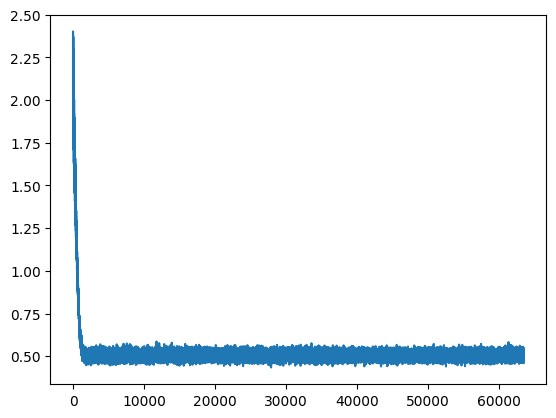

In [20]:
plt.plot(lossi)
#plt.yscale('log')

## Trained Decoder Validation

In [21]:
import warnings
from scipy.stats import ConstantInputWarning

In [22]:
model.eval()
decoder.eval()

BenchmarkDecoder(
  (head): Linear(in_features=256, out_features=1, bias=True)
)

In [23]:
bulk_preds = defaultdict(list)      
bulk_reals = defaultdict(list)     
bulk_reals_delta = defaultdict(list)

val_r2_all = []
val_r2_top50 = []
val_correlations = []
val_mses = []

In [24]:
val_total_examples = 11044
val_steps_per_epoch = val_total_examples // batch_size
val_loader = TrainingLoader(batch_size=batch_size, split='val', data_dir=train_dir, device=DEVICE)


found 1 shards for split val
loading /home/ubuntu/training/val/shard_k562e_val_0000.npz


In [25]:
for step in tqdm(range(val_steps_per_epoch), desc='Benchmarking'):
    
    cont_x, cont_tot, case_x, case_tot, p_idx, p_mod, p_mode = val_loader.next_batch()
    p_feats = input_bank[p_idx]
    B, N = cont_x.shape
    
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot, mask_idx=None)
        action_latents = model.composer(p_feats, p_mod, p_mode)
        
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, action_latents, target_indices)
        
        pred_delta = decoder(z_pred_mu) - decoder(z_context)
        real_delta = case_x - cont_x

        pred_absolute = cont_x + pred_delta
    
    pred_delta_np = pred_delta.cpu().numpy()
    real_delta_np = real_delta.cpu().numpy()

    pred_abs_np = pred_absolute.cpu().numpy()
    real_abs_np = case_x.cpu().numpy()
    
    act_id_np = p_idx.cpu().numpy().flatten()

    for i in range(B):
        p_delta = pred_delta_np[i]
        t_delta = real_delta_np[i]
        pid = act_id_np[i] 

        val_mses.append(np.mean((p_delta - t_delta)**2))

        top_20_idx = np.argsort(np.abs(t_delta))[-20:]
        p_top = p_delta[top_20_idx]
        t_top = t_delta[top_20_idx]
        
        if np.std(p_top) > 1e-9 and np.std(t_top) > 1e-9:
            corr, _ = pearsonr(p_top, t_top)
            val_correlations.append(0.0 if np.isnan(corr) else corr)
        else:
            val_correlations.append(0.0)

        bulk_preds[pid].append(pred_abs_np[i])
        bulk_reals[pid].append(real_abs_np[i])
        bulk_reals_delta[pid].append(real_delta_np[i])

Benchmarking: 100%|████████████████████████████████████████████████████| 345/345 [00:35<00:00,  9.86it/s]


In [26]:
for pid in bulk_preds:
    p_mean = np.mean(np.stack(bulk_preds[pid]), axis=0)
    t_mean = np.mean(np.stack(bulk_reals[pid]), axis=0)
    t_mean_delta = np.mean(np.stack(bulk_reals_delta[pid]), axis=0)

    if np.std(t_mean) > 1e-9:
        val_r2_all.append(r2_score(t_mean, p_mean))
    
    top_50_idx = np.argsort(np.abs(t_mean_delta))[-50:] 
    
    val_r2_top50.append(r2_score(t_mean[top_50_idx], p_mean[top_50_idx]))

In [27]:
val_mean_mse = np.mean(val_mses)
val_mean_corr = np.mean(val_correlations)
val_mean_r2_all = np.mean(val_r2_all)
val_median_r2_all = np.median(val_r2_all)
val_mean_r2_top50 = np.mean(val_r2_top50)
val_median_r2_top50 = np.median(val_r2_top50)

In [28]:
print(f'Global MSE: {val_mean_mse:.4f}')
print(f'Top-20 Pearson R: {val_mean_corr:.4f}')
print(f'R^2 (All Genes): Mean: {val_mean_r2_all:.4f}, Median: {val_median_r2_all:.4f}')
print(f'R^2 (Top 50 DEGs): Mean: {val_mean_r2_top50:.4f}, Median: {val_median_r2_top50:.4f}')

Global MSE: 0.5006
Top-20 Pearson R: 0.9271
R^2 (All Genes): Mean: 0.9166, Median: 0.9235
R^2 (Top 50 DEGs): Mean: 0.0659, Median: 0.2326


## Trained Decoder Evaluation

In [29]:
bulk_preds = defaultdict(list)
bulk_reals = defaultdict(list)
bulk_reals_delta = defaultdict(list)

test_r2_all = []
test_r2_top50 = []
test_correlations = []
test_mses = []

In [30]:
test_total_examples = 38829
test_loader = TrainingLoader(batch_size=batch_size, split='test', data_dir=train_dir, device=DEVICE)
test_steps_per_epoch = test_total_examples // batch_size


found 2 shards for split test
loading /home/ubuntu/training/test/shard_k562e_test_0000.npz


In [31]:
for step in tqdm(range(test_steps_per_epoch), desc='Benchmarking'):
    
    cont_x, cont_tot, case_x, case_tot, p_idx, p_mod, p_mode = test_loader.next_batch()
    p_feats = input_bank[p_idx]
    B, N = cont_x.shape
    
    with torch.no_grad():
        z_context = model.student(cont_x, cont_tot, mask_idx=None)
        action_latents = model.composer(p_feats, p_mod, p_mode)
        
        target_indices = torch.arange(N, device=DEVICE).expand(B, N)
        z_pred_mu, _ = model.predictor(z_context, action_latents, target_indices)
        
        pred_delta = decoder(z_pred_mu) - decoder(z_context)
        real_delta = case_x - cont_x

        pred_absolute = cont_x + pred_delta
        pred_absolute = torch.clamp(pred_absolute, min=0.0)
    
    pred_delta_np = pred_delta.cpu().numpy()
    real_delta_np = real_delta.cpu().numpy()

    pred_abs_np = pred_absolute.cpu().numpy()
    real_abs_np = case_x.cpu().numpy()
    
    act_id_np = p_idx.cpu().numpy().flatten()


    for i in range(B):
        p_delta = pred_delta_np[i]
        t_delta = real_delta_np[i]
        pid = act_id_np[i] 

        test_mses.append(np.mean((p_delta - t_delta)**2))

        top_20_idx = np.argsort(np.abs(t_delta))[-20:]
        p_top = p_delta[top_20_idx]
        t_top = t_delta[top_20_idx]
        
        if np.std(p_top) > 1e-9 and np.std(t_top) > 1e-9:
            corr, _ = pearsonr(p_top, t_top)
            test_correlations.append(0.0 if np.isnan(corr) else corr)
        else:
            test_correlations.append(0.0)

        bulk_preds[pid].append(pred_abs_np[i])
        bulk_reals[pid].append(real_abs_np[i])
        bulk_reals_delta[pid].append(real_delta_np[i])

Benchmarking:  43%|██████████████████████                             | 525/1213 [00:53<01:09,  9.83it/s]/tmp/ipykernel_14905/2029734354.py:41: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(p_top, t_top)
Benchmarking:  52%|██████████████████████████▎                        | 625/1213 [01:03<00:59,  9.83it/s]

loading /home/ubuntu/training/test/shard_k562e_test_0001.npz


Benchmarking: 100%|██████████████████████████████████████████████████| 1213/1213 [02:03<00:00,  9.81it/s]


In [32]:
for pid in bulk_preds:
    p_mean = np.mean(np.stack(bulk_preds[pid]), axis=0)
    t_mean = np.mean(np.stack(bulk_reals[pid]), axis=0)
    t_mean_delta = np.mean(np.stack(bulk_reals_delta[pid]), axis=0)

    if np.std(t_mean) > 1e-9:
        test_r2_all.append(r2_score(t_mean, p_mean))
    
    top_50_idx = np.argsort(np.abs(t_mean_delta))[-50:] 
    
    test_r2_top50.append(r2_score(t_mean[top_50_idx], p_mean[top_50_idx]))

In [33]:
test_mean_mse = np.mean(test_mses)
test_mean_corr = np.mean(test_correlations)
test_mean_r2_all = np.mean(test_r2_all)
test_median_r2_all = np.median(test_r2_all)
test_mean_r2_top50 = np.mean(test_r2_top50)
test_median_r2_top50 = np.median(test_r2_top50)

In [34]:
print(f'Global MSE: {test_mean_mse:.4f}')
print(f'Top-20 Pearson R: {test_mean_corr:.4f}')
print(f'R^2 (All Genes) - Mean: {test_mean_r2_all:.4f}, Median: {test_median_r2_all:.4f}')
print(f'R^2 (Top 50 DEGs) - Mean: {test_mean_r2_top50:.4f}, Median: {test_median_r2_top50:.4f}')

Global MSE: 0.4979
Top-20 Pearson R: 0.9266
R^2 (All Genes) - Mean: 0.9175, Median: 0.9272
R^2 (Top 50 DEGs) - Mean: 0.0962, Median: 0.3211


In [36]:
diff = np.abs(pred_absolute.cpu().numpy() - cont_x.cpu().numpy()).mean()
print(f"Average Predicted Shift magnitude: {diff:.4f}")

Average Predicted Shift magnitude: 0.5379


In [37]:
## most of these are either turning on (true change == true) or off (true == 0) 
print(f'True Change | Pred | True | Error | How much of change missed')
for i in top_50_idx:
    print(f'{t_mean_delta[i]:.4f} | {p_mean[i]:.4f} | {t_mean[i]:.4f} | {(p_mean[i] - t_mean[i]):.4f} | {((p_mean[i] - t_mean[i])/(t_mean_delta[i])):.2f}')
    

True Change | Pred | True | Error | How much of change missed
0.8229 | 0.4887 | 0.8229 | -0.3341 | -0.41
0.8242 | 0.2069 | 0.9653 | -0.7584 | -0.92
0.8246 | 0.8343 | 1.6169 | -0.7826 | -0.95
-0.8279 | 0.3082 | 0.0000 | 0.3082 | -0.37
0.8334 | 0.6302 | 0.9833 | -0.3530 | -0.42
0.8338 | 0.7487 | 1.0090 | -0.2603 | -0.31
0.8353 | 0.4204 | 0.9895 | -0.5691 | -0.68
0.8486 | 0.3425 | 0.8486 | -0.5061 | -0.60
-0.8495 | 1.1056 | 0.7253 | 0.3803 | -0.45
-0.8530 | 1.0213 | 0.8724 | 0.1489 | -0.17
0.8541 | 0.6795 | 1.5019 | -0.8224 | -0.96
0.8554 | 0.7172 | 1.3824 | -0.6652 | -0.78
0.8572 | 0.9089 | 1.5562 | -0.6473 | -0.76
-0.8582 | 0.4284 | 0.1519 | 0.2765 | -0.32
0.8601 | 1.3922 | 2.1323 | -0.7401 | -0.86
0.8629 | 0.5675 | 1.2034 | -0.6358 | -0.74
0.8631 | 0.8959 | 1.5717 | -0.6758 | -0.78
0.8644 | 0.3559 | 1.1751 | -0.8192 | -0.95
0.8705 | 0.6710 | 1.0491 | -0.3781 | -0.43
-0.8720 | 0.5656 | 0.1487 | 0.4169 | -0.48
-0.8731 | 0.9748 | 0.5155 | 0.4594 | -0.53
-0.8832 | 0.4774 | 0.0000 | 0.4774 